In [1]:
!uv pip install -r requirements.txt

Resolved 148 packages in 435ms                                               
Downloaded 1 package in 91mst==8.6.1                                
Installed 4 packages in 121ms                                       
 - dill==0.3.1.1
 + dill==0.3.8
 - jupyter-client==8.2.0
 + jupyter-client==8.6.1
 - pandas==2.0.3
 + pandas==2.2.2
 - pyarrow==14.0.2
 + pyarrow==16.0.0


### --- Import Libraries ---


In [2]:
import io
from datetime import datetime, timedelta

import ee
from google.api_core import exceptions, retry

import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import requests
from typing import List, Tuple

### --- Constants and Earth Engine Initialization ---


In [3]:
SCALE = 5000  # meters per pixel
WORLD_SCALE = 10_000
LAND_COVER_DATASET = "GOOGLE/DYNAMICWORLD/V1"  # Dynamic World Land Cover dataset
LAND_COVER_BAND = "Map"  # Land cover classification band
WORLD_POLYGONS = [
    # Americas
    [(-33.0, -7.0), (-55.0, 53.0), (-166.0, 65.0), (-68.0, -56.0)],
    # Africa, Asia, Europe
    [
        (74.0, 71.0),
        (166.0, 55.0),
        (115.0, -11.0),
        (74.0, -4.0),
        (20.0, -38.0),
        (-29.0, 25.0),
    ],
    # Australia
    [(170.0, -47.0), (179.0, -37.0), (167.0, -12.0), (128.0, 17.0), (106.0, -29.0)],
]
POLYGON = [(-140.0, 60.0), (-140.0, -60.0), (-10.0, -60.0), (-10.0, 60.0)]

### --- Earth Engine Initialization ---


In [4]:
project = "ee-rohitp934"
# Use cli to authenticate
# !earthengine authenticate


# Or use the following code to authenticate
def initialize_ee():
    ee.Authenticate()
    ee.Initialize(
        project=project, opt_url="https://earthengine-highvolume.googleapis.com"
    )

In [5]:
initialize_ee()

### --- Data Retreival Functions ---


In [6]:
def get_modis_ndvi(date: datetime) -> ee.Image:
    """Gets MODIS NDVI data for a given date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(1, "month")
    return (
        ee.ImageCollection("MODIS/061/MOD13Q1")
        .filterDate(start_date, end_date)
        .select("NDVI")
        .first()
        .unmask(0)
        .float()
    )

In [ ]:
import geemap


def render_modis(image: ee.Image) -> geemap.Map:
    """Renders a Modis image."""

    LONLAT = -121.526, 39.781
    VIS_PARAMS = {
        "bands": ["NDVI"],
        "min": 0,
        "max": 8000,
        "palette": [
            "ffffff",
            "ce7e45",
            "df923d",
            "f1b555",
            "fcd163",
            "99b718",
            "74a901",
            "66a000",
            "529400",
            "3e8601",
            "207401",
            "056201",
            "004c00",
            "023b01",
            "012e01",
            "011d01",
            "011301",
        ],
    }
    map = geemap.Map()
    map.set_center(LONLAT[0], LONLAT[1], 9)
    map.scroll_wheel_zoom = False
    map.dragging = False
    map.add_layer(image, VIS_PARAMS, "Landsat 8 Satellite Image")
    map.addLayerControl()
    return map


render_modis(get_modis_ndvi(datetime.strptime("2020-01-01", "%Y-%m-%d")))

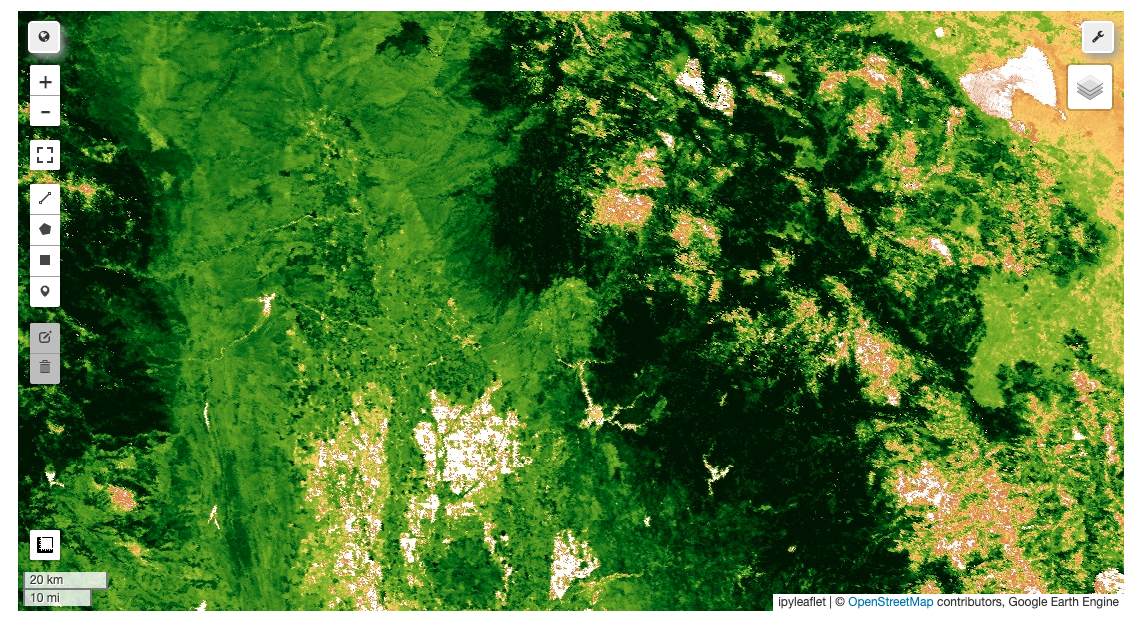

In [8]:
def mask_landsat8_clouds(image: ee.Image) -> ee.Image:
    """Mask clouds in Landsat 8 images."""
    CLOUD_SHADOW_BIT = 3
    CLOUD_BIT = 5
    qa = image.select("QA_PIXEL")
    cloud_mask = (
        qa.bitwiseAnd(1 << CLOUD_SHADOW_BIT)
        .eq(0)
        .And(qa.bitwiseAnd(1 << CLOUD_BIT).eq(0))
    )
    return image.updateMask(cloud_mask)

In [9]:
def apply_scale_factors(image):
    """Apply scale factors to Landsat 8 bands."""
    optical_bands = image.select("SR_B.").multiply(0.0000275).add(-0.2)
    thermal_bands = image.select("ST_B.*").multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

In [10]:
def get_landsat_image(date: datetime) -> ee.Image:
    """Gets a Landsat 8 image for the selected date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(6, "month")
    return (
        ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
        .filterDate(start_date, end_date)
        .map(mask_landsat8_clouds)
        .map(apply_scale_factors)
        .mosaic()
        .unmask(0)
        .float()
    )

In [ ]:
import geemap


def render_landsat(image: ee.Image) -> geemap.Map:
    """Renders a Landsat image."""

    LONLAT = -121.526, 39.781
    VIS_PARAMS = {
        "bands": ["SR_B4", "SR_B3", "SR_B2"],
        "min": 0,
        "max": 0.3,
        # "palette": [
        # ],
    }
    map = geemap.Map()
    map.set_center(LONLAT[0], LONLAT[1], 9)
    map.scroll_wheel_zoom = False
    map.dragging = False
    map.add_layer(image, VIS_PARAMS, "Landsat 8 Satellite Image")
    map.addLayerControl()
    return map


render_landsat(get_landsat_image(datetime.strptime("2020-01-01", "%Y-%m-%d")))

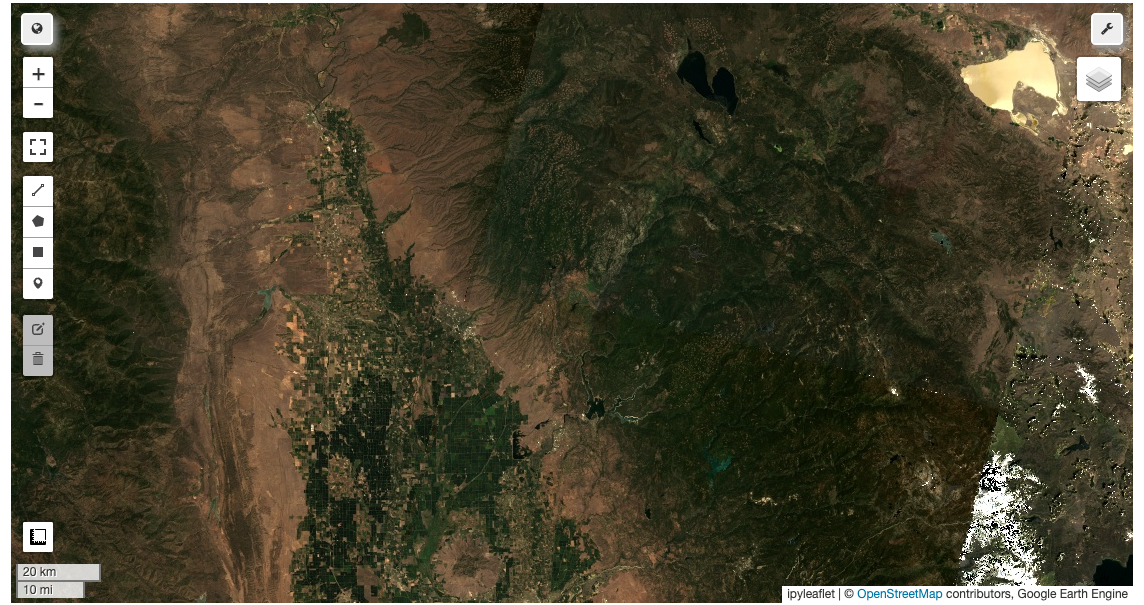

In [12]:
def get_landsat_ndvi(image: ee.Image) -> ee.Image:
    """Calculates NDVI from a Landsat 8 image."""
    return image.normalizedDifference(["SR_B5", "SR_B4"]).rename("NDVI")

In [13]:
def get_landsat_lst(image: ee.Image) -> ee.Image:
    """
    Calculates Land Surface Temperature from a Landsat 8 image.
    This function is based on the formula in the following page https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2
    """
    return image.select("ST_B10").rename("LST")

In [14]:
def get_land_cover(date: datetime, advance: int = 6) -> ee.Image:
    """Gets a Land Cover image for the given date."""
    start_date = ee.Date(date)
    end_date = ee.Date(date).advance(advance, "month")
    return (
        ee.ImageCollection(LAND_COVER_DATASET)
        .filterDate(start_date, end_date)
        .select("label")
        .mosaic()
        .unmask(0)  # fill missing values with 0 (water)
        .byte()
    )

In [15]:
def get_lst(date: datetime) -> ee.Image:
    """Gets the Land Surface Temperature for the given date."""

    landsat_image = get_landsat_image(date)

    return get_landsat_lst(landsat_image)

### --- Input and Label Image Composition ---


In [16]:
def get_inputs_image(date: datetime) -> ee.Image:
    """Gets an Earth Engine image with all the inputs for the model."""
    # Get MODIS NDVI
    modis_ndvi = get_modis_ndvi(date)

    # Get Landsat data
    landsat_image = get_landsat_image(date)
    landsat_ndvi = get_landsat_ndvi(landsat_image)
    landsat_lst = get_landsat_lst(landsat_image)

    combined_ndvi = ee.Image.cat([landsat_ndvi, modis_ndvi])

    # Combine all input data
    return ee.Image([combined_ndvi, landsat_lst])

In [ ]:
import geemap


def render_input(image: ee.Image) -> geemap.Map:
    """Renders a Modis image."""

    LONLAT = -121.526, 39.781
    VIS_PARAMS = {
        "bands": ["NDVI"],
        "min": -1,
        "max": 1,
        "palette": [
            "ffffff",
            "ce7e45",
            "df923d",
            "f1b555",
            "fcd163",
            "99b718",
            "74a901",
            "66a000",
            "529400",
            "3e8601",
            "207401",
            "056201",
            "004c00",
            "023b01",
            "012e01",
            "011d01",
            "011301",
        ],
    }
    map = geemap.Map()
    map.set_center(LONLAT[0], LONLAT[1], 9)
    map.scroll_wheel_zoom = False
    map.dragging = False
    map.add_layer(image, VIS_PARAMS, "Landsat 8 Satellite Image")
    map.addLayerControl()
    return map


render_input(
    get_landsat_ndvi(get_landsat_image(datetime.strptime("2020-01-01", "%Y-%m-%d")))
)

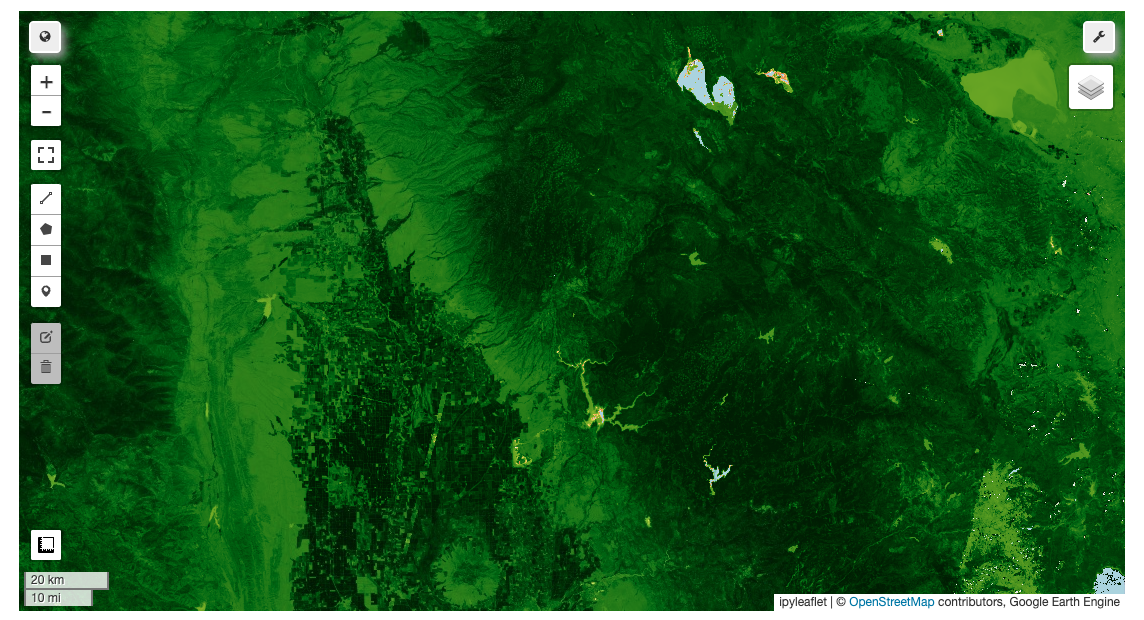

### --- Get input and labels for a given latitude and longitude ---


In [18]:
@retry.Retry(deadline=10 * 60)  # seconds
def get_patch(
    image: ee.Image, lonlat: Tuple[float, float], patch_size: int, scale: int
) -> np.ndarray:
    """Fetches a patch of pixels from Earth Engine."""
    point = ee.Geometry.Point(lonlat)
    url = image.getDownloadURL(
        {
            "region": point.buffer(scale * patch_size / 2, 1).bounds(1),
            "dimensions": [patch_size, patch_size],
            # "scale": SCALE,
            "format": "NPY",
        }
    )

    # Retry on "Too Many Requests" errors
    response = requests.get(url)
    if response.status_code == 429:
        raise exceptions.TooManyRequests(response.text)

    # Raise other exceptions
    response.raise_for_status()
    return np.load(io.BytesIO(response.content), allow_pickle=True)

In [19]:
def get_inputs_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the inputs patch of pixels for the given point and date."""
    image = get_inputs_image(date)
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)


def get_labels_landcover_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the labels patch of pixels in LandCover for the given point and year."""
    image = get_land_cover(date + timedelta(weeks=24))
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)


def get_labels_lst_patch(
    date: datetime, lonlat: Tuple[float, float], patch_size: int
) -> np.ndarray:
    """Gets the labels patch of pixels in LST for the given point and year."""
    image = get_lst(date + timedelta(weeks=24))
    patch = get_patch(image, lonlat, patch_size, SCALE)
    return structured_to_unstructured(patch)

## Creating the dataset


### --- Imports ---


In [20]:
import logging
import random
from datetime import datetime

import numpy as np
import os
import uuid
from typing import Tuple, List

### --- Configs ---


In [22]:
NUM_SAMPLES = 250
PARTITION_SIZE = 4
NUM_SAMPLES_PER_PARTITION = NUM_SAMPLES // PARTITION_SIZE
PATCH_SIZE = 512
START_DATE = "2015-01-01"
END_DATE = "2021-01-01"

### --- Sample Points ---


In [23]:
def random_date(start: datetime, end: datetime):
    """Generate a random datetime between `start` and `end`"""
    return start + timedelta(
        # Get a random amount of seconds between `start` and `end`
        seconds=random.randint(0, int((end - start).total_seconds())),
    )

In [24]:
def sample_points(seed: int) -> List[Tuple[datetime, Tuple[float, float]]]:
    global numFailures, numSuccesses, dates
    """Samples points within the defined polygon for the given year."""
    initialize_ee()
    updated_dates: List[datetime] = [d + timedelta(days=(30 * seed)) for d in dates]
    results = []
    for date in updated_dates:
        tries = 2
        advance = 6
        while tries > 0:
            try:
                land_cover = get_land_cover(date, advance)
                # snapshot_date = land_cover.date().format().getInfo()
                # snapshot_date = datetime.strptime(snapshot_date, "%Y-%m-%dT%H:%M:%S")
                points = land_cover.stratifiedSample(
                    numPoints=NUM_SAMPLES_PER_PARTITION,
                    region=ee.Geometry.MultiPolygon(WORLD_POLYGONS),
                    scale=WORLD_SCALE,
                    geometries=True,
                    seed=seed,
                    classBand="label",
                    tileScale=4,
                )
                if int(points.size().getInfo()) > 0:
                    features = points.getInfo()["features"]
                    for feature in features:
                        results.append((date, feature["geometry"]["coordinates"]))
                    break
                tries -= 1
            except Exception as e:
                tries -= 1
                advance = 3
                print(f"Error occurred for {date}: {e} ... Retrying {tries} times")

    return results

### --- Prepare Training Data ---


In [25]:
def get_training_example(
    date: datetime, point: Tuple[float, float]
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Gets an (inputs, labels) training example for land cover change prediction."""
    inputs = get_inputs_patch(date, point, PATCH_SIZE)

    labels_landcover = get_labels_landcover_patch(
        date + timedelta(days=1), point, PATCH_SIZE
    )
    labels_lst = get_labels_lst_patch(date + timedelta(days=1), point, PATCH_SIZE)
    return (inputs, labels_landcover, labels_lst)

In [26]:
def try_get_example(
    sample_point: Tuple[datetime, Tuple[float, float]],
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Wrapper to handle errors during training data generation."""
    ee.Initialize(project=project)
    date, point = sample_point
    try:
        return get_training_example(date, point)
    except Exception as e:
        print(f"Error occurred: {e}")

# --- Beam Workflow for Dataset Creation ---

In [27]:
def write_npz(
    data: List[Tuple[np.ndarray, np.ndarray, np.ndarray]], data_path: str
) -> str:
    """Writes an (inputs, labels) set of data into a compressed NumPy file.

    Args:
        batch: Batch of (inputs, labels) pairs of NumPy arrays.
        data_path: Directory path to save files to.

    Returns: The filename of the data file.
    """
    initialize_ee()
    filename = os.path.join(data_path, f"{uuid.uuid4()}.npz")
    with open(filename, "xb") as f:
        inputs = [x for (x, _, _) in data]
        labels_landcover = [y for (_, y, _) in data]
        labels_lst = [z for (_, _, z) in data]
        np.savez_compressed(
            f, inputs=inputs, labels_landcover=labels_landcover, labels_lst=labels_lst
        )
    logging.info(filename)
    return filename

In [28]:
start_date = datetime.strptime(START_DATE, "%Y-%m-%d")
end_date = datetime.strptime(END_DATE, "%Y-%m-%d")

years = range(start_date.year, end_date.year + 1)
dates = [datetime(year, 1, 1) for year in years if year != 2020]


print(dates)

[datetime.datetime(2015, 1, 1, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2017, 1, 1, 0, 0), datetime.datetime(2018, 1, 1, 0, 0), datetime.datetime(2019, 1, 1, 0, 0), datetime.datetime(2021, 1, 1, 0, 0)]


In [29]:
points = None

### --- Perform Dataset Creation ---

In [ ]:
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions


beam_options = PipelineOptions(
    [],
    # save_main_session=True,
    # setup_file="./setup.py",
    # max_num_workers=max_requests,
    direct_running_mode="multi_threading",  # distributed runners
    direct_num_workers=4,  # direct runner
    # disk_size_gb=50,
)
intermediate_path = "data/v2/intermediate"

with beam.Pipeline(options=beam_options) as pipeline:

    def post_process(data: Tuple[datetime, Tuple[float, float]]) -> str:
        """Post process data to write into an intermediate txt file"""
        date, coords = data
        return f"{date.strftime('%Y-%m-%d')},{coords[0]},{coords[1]}"

    (
        pipeline
        | "🌱 Make seeds" >> beam.Create(range(4))
        | "📌 Sample points" >> beam.FlatMap(sample_points)
        | "📝 Post process" >> beam.Map(post_process)
        | "📝 Write Intermediate results"
        >> beam.io.WriteToText(intermediate_path + "/inter")
    )

In [ ]:
with beam.Pipeline(options=beam_options) as pipeline:

    def process(line: str) -> Tuple[datetime, Tuple[float, float]]:
        """Processes a line of text and returns a tuple of (date, point)."""
        date, lat, lon = line.split(",")
        return (datetime.strptime(date, "%Y-%m-%d"), [float(lat), float(lon)])

    points = pipeline | "Read points" >> beam.io.ReadFromText(intermediate_path + "/*")

    (
        points
        | "🃏 Reshuffle" >> beam.Reshuffle()
        | "📂 Map to tuple" >> beam.Map(process)
        | "📑 Get examples" >> beam.Map(try_get_example)
        | "🗂️ Batch examples" >> beam.BatchElements(10)
        | "📝 Write NPZ Files"
        >> beam.Map(write_npz, data_path="data/v4/climate_change")
        # | "Print" >> beam.Map(print)
    )